## FNNNeurons: Alternate Dataset - 8 Neuron Investigation of Epoch

### Goal: Here, the investigation will focus on the 8 layer network, but looking into the epochs to see the active learning. 

### TODO: IMPLEMENT NEW DATA

### https://www.kaggle.com/datasets/prathamtripathi/drug-classification

### 0. Imports

In [3]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import scipy
import numpy as np
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

### 1. Read Data

In [4]:
diabetes_data = pd.read_csv('raw_data/diabetes.csv')
diabetes_data.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


### 2. Prepare Data

In [5]:
diabetes_data['Gender'] = diabetes_data['Gender'].map({'Male': 0, 'Female': 1})             
diabetes_data['Polyuria'] = diabetes_data['Polyuria'].map({'No': 0, 'Yes': 1})
diabetes_data['Polydipsia'] = diabetes_data['Polydipsia'].map({'No': 0, 'Yes': 1})
diabetes_data['sudden weight loss'] = diabetes_data['sudden weight loss'].map({'No': 0, 'Yes': 1})
diabetes_data['weakness'] = diabetes_data['weakness'].map({'No': 0, 'Yes': 1})
diabetes_data['Polyphagia'] = diabetes_data['Polyphagia'].map({'No': 0, 'Yes': 1})
diabetes_data['Genital thrush'] = diabetes_data['Genital thrush'].map({'No': 0, 'Yes': 1})
diabetes_data['visual blurring'] = diabetes_data['visual blurring'].map({'No': 0, 'Yes': 1})
diabetes_data['Itching'] = diabetes_data['Itching'].map({'No': 0, 'Yes': 1})
diabetes_data['Irritability'] = diabetes_data['Irritability'].map({'No': 0, 'Yes': 1})
diabetes_data['delayed healing'] = diabetes_data['delayed healing'].map({'No': 0, 'Yes': 1})
diabetes_data['partial paresis'] = diabetes_data['partial paresis'].map({'No': 0, 'Yes': 1})
diabetes_data['muscle stiffness'] = diabetes_data['muscle stiffness'].map({'No': 0, 'Yes': 1})
diabetes_data['Alopecia'] = diabetes_data['Alopecia'].map({'No': 0, 'Yes': 1})
diabetes_data['Obesity'] = diabetes_data['Obesity'].map({'No': 0, 'Yes': 1})

# target
diabetes_data['class'] = diabetes_data['class'].map({'Negative': 0, 'Positive': 1})


In [6]:
scaler_minmax = MinMaxScaler()
scaled_data = scaler_minmax.fit_transform(diabetes_data.drop(columns=['class']))
X = scaled_data
y = diabetes_data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train = X_train.to_numpy()
#X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# convert to tensors
X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)

### 3. Create NN

#### 3.1: 8 Neurons

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 8)
        self.fc2 = nn.Linear(8,8)
        self.fc3 = nn.Linear(8,8)
        self.fc4 = nn.Linear(8,8)
        self.fc5 = nn.Linear(8,8)
        self.output_layer = nn.Linear(8, 1)


    # feedforward function
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        x = torch.relu(x)
        x = self.fc5(x)
        x = torch.relu(x)
        x = self.output_layer(x)
        return x

#### 4. Train Model

##### 4.1: 8 Neurons

In [8]:
# variables needed
input_size = X_train.shape[1]

# initialize model
model = NeuralNetwork(input_size)

# loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), 0.001)

# training accuracy tracker
train_accuracy = {"epoch": [], "accuracy": []}
weights_by_epoch = {"epoch": [], "weights_l1": [], "weights_l2": [], "weights_l3": [], "weights_l4": [], "weights_l5": []}

# number of training loops
epochs = 500

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train_tensor)


    y_train_tensor = y_train_tensor.view(-1, 1)
    loss = criterion(output, y_train_tensor)

    loss.backward()

    optimizer.step()
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            model.eval()

            outputs = model(X_train_tensor)
            probabilities = torch.sigmoid(outputs)

            predictions = (probabilities > 0.5).float()

            accuracy = (y_train_tensor.flatten() == predictions.flatten()).float().mean()

            train_accuracy["epoch"].append(epoch)
            train_accuracy["accuracy"].append(accuracy.item())
            weights_by_epoch["epoch"].append(epoch)
            weights_by_epoch["weights_l1"].append(model.fc1.weight.data.numpy().flatten())
            weights_by_epoch["weights_l2"].append(model.fc2.weight.data.numpy().flatten())
            weights_by_epoch["weights_l3"].append(model.fc3.weight.data.numpy().flatten())
            weights_by_epoch["weights_l4"].append(model.fc4.weight.data.numpy().flatten())
            weights_by_epoch["weights_l5"].append(model.fc5.weight.data.numpy().flatten())
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item()* 100:.2f}%')
        

model_train_acc = accuracy

Epoch [10/500], Loss: 0.7031, Accuracy: 40.14%
Epoch [20/500], Loss: 0.6980, Accuracy: 40.14%
Epoch [30/500], Loss: 0.6935, Accuracy: 43.51%
Epoch [40/500], Loss: 0.6890, Accuracy: 59.86%
Epoch [50/500], Loss: 0.6843, Accuracy: 59.86%
Epoch [60/500], Loss: 0.6804, Accuracy: 59.86%
Epoch [70/500], Loss: 0.6763, Accuracy: 59.86%
Epoch [80/500], Loss: 0.6714, Accuracy: 59.86%
Epoch [90/500], Loss: 0.6646, Accuracy: 59.86%
Epoch [100/500], Loss: 0.6552, Accuracy: 59.86%
Epoch [110/500], Loss: 0.6421, Accuracy: 59.86%
Epoch [120/500], Loss: 0.6249, Accuracy: 59.86%
Epoch [130/500], Loss: 0.6035, Accuracy: 59.86%
Epoch [140/500], Loss: 0.5750, Accuracy: 59.86%
Epoch [150/500], Loss: 0.5353, Accuracy: 77.40%
Epoch [160/500], Loss: 0.4842, Accuracy: 89.18%
Epoch [170/500], Loss: 0.4311, Accuracy: 90.62%
Epoch [180/500], Loss: 0.3803, Accuracy: 92.31%
Epoch [190/500], Loss: 0.3351, Accuracy: 93.51%
Epoch [200/500], Loss: 0.2973, Accuracy: 95.91%
Epoch [210/500], Loss: 0.2646, Accuracy: 95.91%
E

### 5. Evaluation

##### 5.1: 8 Neurons

In [9]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    
    probabilities = torch.sigmoid(outputs)

    predictions = (probabilities > 0.5).float()

    accuracy = (y_test_tensor.flatten() == predictions.flatten()).float().mean()

print(f"Accuracy: {accuracy.item()* 100:.2f}%")
model_test_acc = accuracy.item()*100

Accuracy: 95.19%


#### 6. Weight Investigation

##### 6.1: 8 Neurons

In [10]:
# dictionary to hold names and weights associated with each layer
model_dict = {"name":[], "weights":[]}

for name, param in model.state_dict().items():
    model_dict["name"].append(name)
    model_dict["weights"].append(param.data.numpy())

##### 6.2: 5 Layers by Epoch

In [11]:
weights_by_epoch_df = pd.DataFrame(weights_by_epoch)
weights_by_epoch_df.head()

,epoch,weights_l1,weights_l2,weights_l3,weights_l4,weights_l5
0,9,"[0.22541188, 0.11850798, -0.2129737, 0.0090274...","[-0.15601242, -0.18863854, -0.3234372, -0.1608...","[0.03146866, 0.038273543, -0.2310486, -0.05561...","[-0.21729912, -0.20833828, -0.25842088, -0.191...","[-0.15569425, -0.31939727, -0.25705978, 0.0437..."
1,19,"[0.21782756, 0.10980706, -0.22158742, 0.000394...","[-0.15601242, -0.18863854, -0.3234372, -0.1608...","[0.03146866, 0.038273543, -0.24183829, -0.0556...","[-0.21729912, -0.20833828, -0.25842088, -0.191...","[-0.15569425, -0.31939727, -0.25705978, 0.0437..."
2,29,"[0.2142126, 0.10294217, -0.22856303, -0.006401...","[-0.15601242, -0.18863854, -0.3234372, -0.1608...","[0.03146866, 0.038273543, -0.254068, -0.055612...","[-0.21729912, -0.20833828, -0.25842088, -0.191...","[-0.15569425, -0.31939727, -0.25705978, 0.0437..."
3,39,"[0.21559705, 0.09747189, -0.23410442, -0.01160...","[-0.15601242, -0.18863854, -0.3234372, -0.1608...","[0.03146866, 0.038273543, -0.26779678, -0.0550...","[-0.21729912, -0.20833828, -0.25842088, -0.191...","[-0.15569425, -0.31939727, -0.25705978, 0.0437..."
4,49,"[0.22049028, 0.09166498, -0.23955396, -0.01674...","[-0.15601242, -0.18863854, -0.3234372, -0.1608...","[0.03146866, 0.038273543, -0.28313807, -0.0438...","[-0.21729912, -0.20833828, -0.25842088, -0.191...","[-0.15569425, -0.31939727, -0.25705978, 0.0437..."


In [12]:
weights_by_epoch_df.head()

,epoch,weights_l1,weights_l2,weights_l3,weights_l4,weights_l5
0,9,"[0.22541188, 0.11850798, -0.2129737, 0.0090274...","[-0.15601242, -0.18863854, -0.3234372, -0.1608...","[0.03146866, 0.038273543, -0.2310486, -0.05561...","[-0.21729912, -0.20833828, -0.25842088, -0.191...","[-0.15569425, -0.31939727, -0.25705978, 0.0437..."
1,19,"[0.21782756, 0.10980706, -0.22158742, 0.000394...","[-0.15601242, -0.18863854, -0.3234372, -0.1608...","[0.03146866, 0.038273543, -0.24183829, -0.0556...","[-0.21729912, -0.20833828, -0.25842088, -0.191...","[-0.15569425, -0.31939727, -0.25705978, 0.0437..."
2,29,"[0.2142126, 0.10294217, -0.22856303, -0.006401...","[-0.15601242, -0.18863854, -0.3234372, -0.1608...","[0.03146866, 0.038273543, -0.254068, -0.055612...","[-0.21729912, -0.20833828, -0.25842088, -0.191...","[-0.15569425, -0.31939727, -0.25705978, 0.0437..."
3,39,"[0.21559705, 0.09747189, -0.23410442, -0.01160...","[-0.15601242, -0.18863854, -0.3234372, -0.1608...","[0.03146866, 0.038273543, -0.26779678, -0.0550...","[-0.21729912, -0.20833828, -0.25842088, -0.191...","[-0.15569425, -0.31939727, -0.25705978, 0.0437..."
4,49,"[0.22049028, 0.09166498, -0.23955396, -0.01674...","[-0.15601242, -0.18863854, -0.3234372, -0.1608...","[0.03146866, 0.038273543, -0.28313807, -0.0438...","[-0.21729912, -0.20833828, -0.25842088, -0.191...","[-0.15569425, -0.31939727, -0.25705978, 0.0437..."


In [13]:

weights_by_epoch_df['all_weights_combined'] = weights_by_epoch_df[['weights_l1', 'weights_l2', 'weights_l3', 'weights_l4', 'weights_l5']].apply(lambda x: np.concatenate(x), axis=1)
condensed_weights_by_epoch_df = weights_by_epoch_df.drop(columns=['weights_l1', 'weights_l2', 'weights_l3', 'weights_l4', 'weights_l5'])
condensed_weights_by_epoch_df.head()

/var/folders/tx/n4skssh51z99qfx983_bwgfw0000gn/T/ipykernel_15072/1001148696.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights_by_epoch_df['all_weights_combined'] = weights_by_epoch_df[['weights_l1', 'weights_l2', 'weights_l3', 'weights_l4', 'weights_l5']].apply(lambda x: np.concatenate(x), axis=1)


,epoch,all_weights_combined
0,9,"[0.22541188, 0.11850798, -0.2129737, 0.0090274..."
1,19,"[0.21782756, 0.10980706, -0.22158742, 0.000394..."
2,29,"[0.2142126, 0.10294217, -0.22856303, -0.006401..."
3,39,"[0.21559705, 0.09747189, -0.23410442, -0.01160..."
4,49,"[0.22049028, 0.09166498, -0.23955396, -0.01674..."


#### 7. Visualization

##### 7.1: 8 Neurons Weights by Epoch

Text(138.59722222222223, 0.5, 'Weight Value')

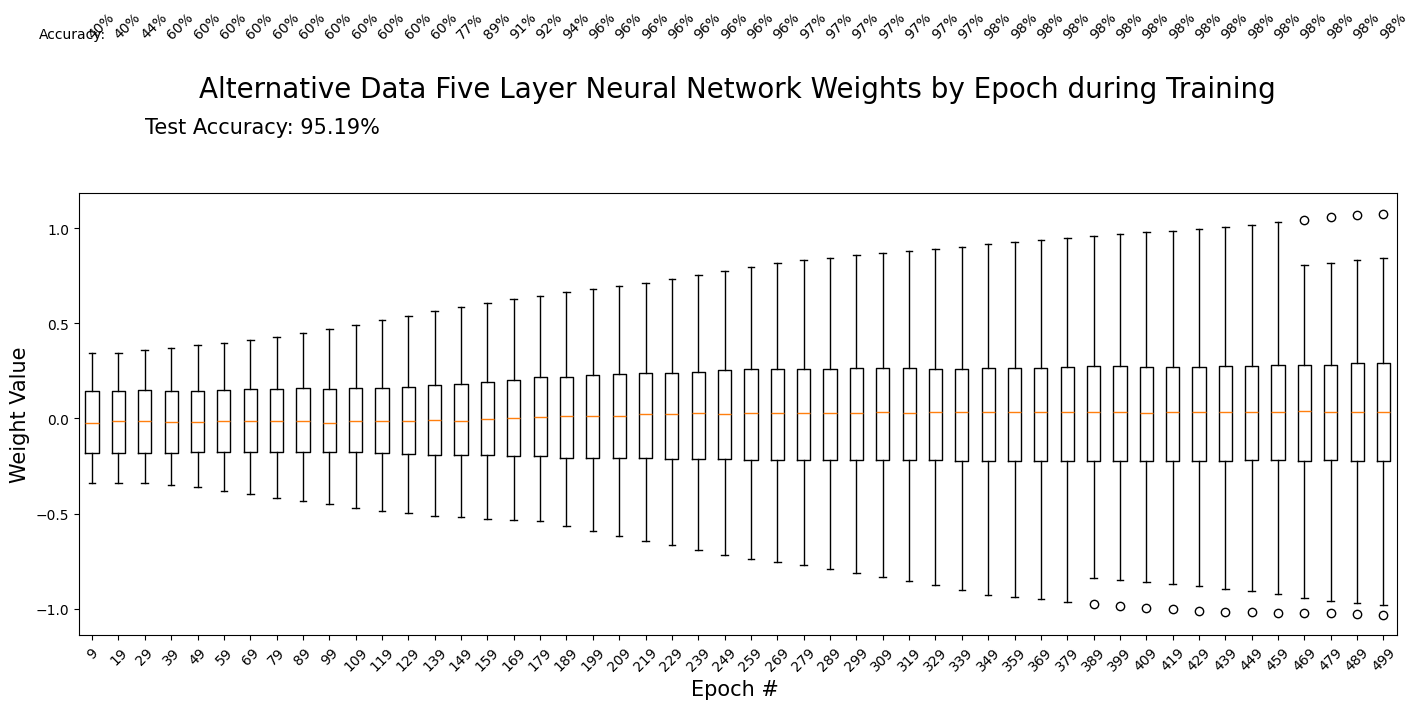

In [23]:
epoch_boxplot_dict = {"boxes":[], "x_labels":[]}
for i in range(0, condensed_weights_by_epoch_df.shape[0]):
    epoch_boxplot_dict["boxes"].append(condensed_weights_by_epoch_df.iloc[i, 1])
    epoch_boxplot_dict["x_labels"].append(condensed_weights_by_epoch_df.iloc[i, 0])

plt.figure(figsize=(15,7.5))
plt.boxplot(epoch_boxplot_dict['boxes'])
plt.title("Alternative Data Five Layer Neural Network Weights by Epoch during Training", y =1.2, fontsize = 20)
plt.tight_layout(pad =5)
plt.text(3, 1.5, f"Test Accuracy: {model_test_acc:.2f}%", fontsize = 15)
plt.xlabel("Epoch # ", fontsize = 15)
x_position = .75
y_position = 2 
x_increment = 1 
for item in train_accuracy["accuracy"]:
    plt.text(x_position, y_position, f"{item*100:.0f}%", rotation = 45, fontsize = 10)
    x_position += x_increment
plt.text(-1, 2, "Accuracy:", fontsize = 10)
plt.xticks(range(1, len(epoch_boxplot_dict['x_labels']) + 1), epoch_boxplot_dict['x_labels'], rotation = 45, fontsize = 10)
plt.ylabel("Weight Value", fontsize = 15)

In [21]:
# for the first epoch recorded (epoch 9)
first_epoch = condensed_weights_by_epoch_df.iloc[0]

# midpoint
midpoint = condensed_weights_by_epoch_df.iloc[condensed_weights_by_epoch_df.shape[0] // 2]

# for the las epoch recorded (epoch 4809)
last_epoch = condensed_weights_by_epoch_df.iloc[-1]


Text(0.5, 1.0, 'Logistic Q-Q Plot')

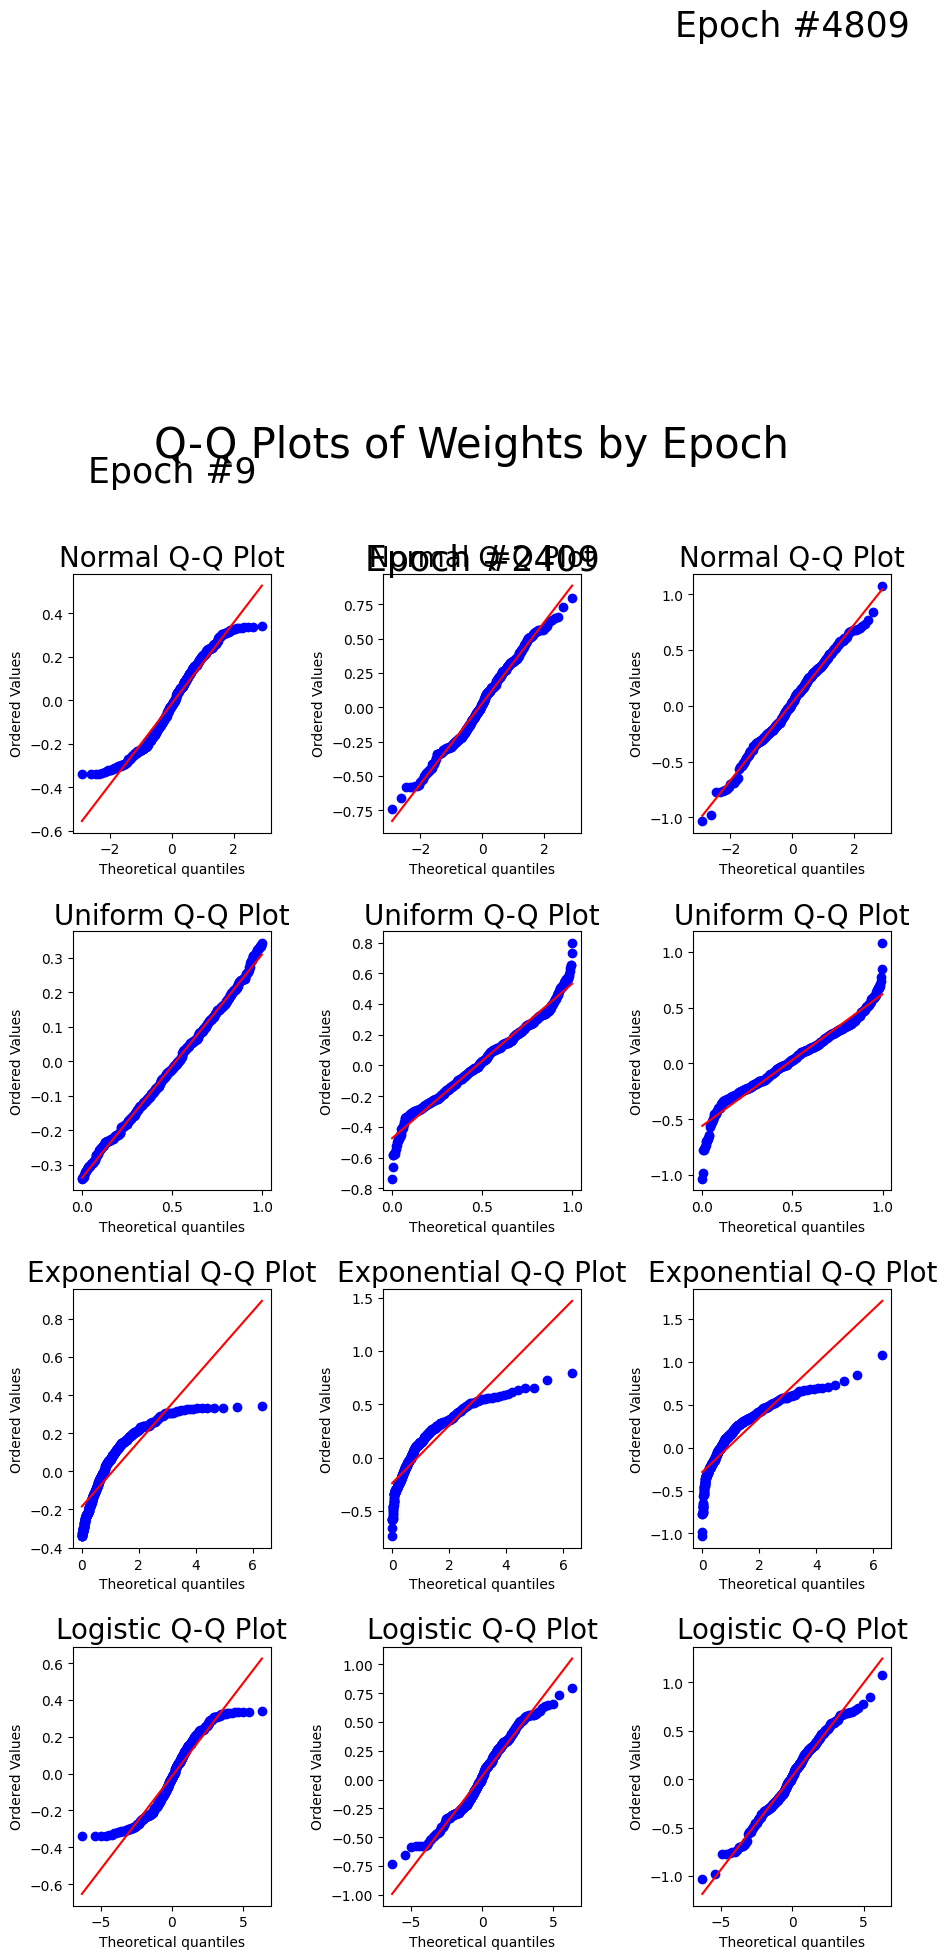

In [22]:
qq_points1 = first_epoch['all_weights_combined']
qq_points2 = midpoint['all_weights_combined']
qq_points3 = last_epoch['all_weights_combined']

fig, axes = plt.subplots(4, 3, figsize=(10, 15))
fig.tight_layout(pad=5)

fig.suptitle("Q-Q Plots of Weights by Epoch", fontsize = 30, y = 1.05)

axes[0,0].text(0, 1, "Epoch #9", fontsize = 25, ha = "center")
stats.probplot(qq_points1, dist = "norm", plot = axes[0,0])
axes[0,0].set_title("Normal Q-Q Plot", fontsize = 20)
stats.probplot(qq_points1, dist = "uniform", plot = axes[1,0])
axes[1,0].set_title("Uniform Q-Q Plot", fontsize = 20)
stats.probplot(qq_points1, dist = "expon", plot = axes[2,0])
axes[2,0].set_title("Exponential Q-Q Plot", fontsize = 20)
stats.probplot(qq_points1, dist = "logistic", plot = axes[3,0])
axes[3,0].set_title("Logistic Q-Q Plot", fontsize = 20)

axes[0,1].text(0, 1, "Epoch #2409", fontsize = 25, ha = "center")
stats.probplot(qq_points2, dist = "norm", plot = axes[0,1])
axes[0,1].set_title("Normal Q-Q Plot", fontsize = 20)
stats.probplot(qq_points2, dist = "uniform", plot = axes[1,1])
axes[1,1].set_title("Uniform Q-Q Plot", fontsize = 20)
stats.probplot(qq_points2, dist = "expon", plot = axes[2,1])
axes[2,1].set_title("Exponential Q-Q Plot", fontsize = 20)
stats.probplot(qq_points2, dist = "logistic", plot = axes[3,1])
axes[3,1].set_title("Logistic Q-Q Plot", fontsize = 20)



axes[0,2].text(0, 6, "Epoch #4809", fontsize = 25, ha = "center")
stats.probplot(qq_points3, dist = "norm", plot = axes[0,2])
axes[0,2].set_title("Normal Q-Q Plot", fontsize = 20)
stats.probplot(qq_points3, dist = "uniform", plot = axes[1,2])
axes[1,2].set_title("Uniform Q-Q Plot", fontsize = 20)
stats.probplot(qq_points3, dist = "expon", plot = axes[2,2])
axes[2,2].set_title("Exponential Q-Q Plot", fontsize = 20)
stats.probplot(qq_points3, dist = "logistic", plot = axes[3,2])
axes[3,2].set_title("Logistic Q-Q Plot", fontsize = 20)



